# TVTW Hotspot Trajectory Analysis

This notebook analyzes trajectories passing through a specific Traffic Volume Time Window (TVTW) hotspot by:
1. Finding all flights that pass through a given traffic_volume_id and time_bin
2. Plotting all trajectories that intersect with the specified TVTW
3. Visualizing the hotspot and flight density

**Usage:** Enter a traffic_volume_id and time_bin to visualize all trajectories passing through that hotspot.

In [61]:
import json
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, LineString
import sys
import os
from collections import defaultdict

# Add the project source to path for imports
sys.path.append('../src')
from project_tailwind.impact_eval.tvtw_indexer import TVTWIndexer

plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)

## User Input

Enter the traffic_volume_id and time_bin you want to analyze:

In [62]:
# USER INPUT: Enter the traffic_volume_id and time_bin to analyze
target_traffic_volume_id = "MASB5KL"  # Example traffic volume ID
target_time_bin = "06:00-06:15"       # Example time bin (format: HH:MM-HH:MM)

print(f"Analyzing TVTW hotspot:")
print(f"Traffic Volume ID: {target_traffic_volume_id}")
print(f"Time Bin: {target_time_bin}")

Analyzing TVTW hotspot:
Traffic Volume ID: MASB5KL
Time Bin: 06:00-06:15


## Load Required Data

In [63]:
# Load impact vectors (new format with timing information)
with open('../output/so6_occupancy_matrix_with_times.json', 'r') as f:
    flight_data = json.load(f)

# Load traffic volumes
traffic_volumes = gpd.read_file('D:/project-cirrus/cases/traffic_volumes_with_capacity.geojson')

# Load TVTW indexer
tvtw_indexer = TVTWIndexer.load('../output/tvtw_indexer.json')

# Load CSV trajectory data
trajectory_df = pd.read_csv('D:/project-cirrus/cases/flights_20230801.csv')

print(f"Loaded {len(flight_data)} flights with occupancy data")
print(f"Loaded {len(traffic_volumes)} traffic volumes")
print(f"TVTW indexer: {len(tvtw_indexer._tv_id_to_idx)} traffic volumes, {tvtw_indexer.time_bin_minutes}min bins")
print(f"Loaded {len(trajectory_df)} trajectory segments")

Skipping field elementary_sectors: unsupported OGR type: 5


Loaded 21577 flights with occupancy data
Loaded 1612 traffic volumes
TVTW indexer: 1612 traffic volumes, 15min bins
Loaded 1214748 trajectory segments


## Analysis Functions

In [64]:
def find_flights_in_tvtw(target_tv_id, target_time_bin, flight_data, tvtw_indexer):
    """
    Find all flights that pass through a specific traffic volume and time bin (TVTW)
    """
    # Get the TVTW index for the target
    target_tvtw_index = None
    print(f"Length of tvtw_indexer._idx_to_tv_id: {len(tvtw_indexer._idx_to_tv_id)}")
    for tvtw_index in range(len(tvtw_indexer.idx_to_tvtw)):
        tvtw_data = tvtw_indexer.get_human_readable_tvtw(tvtw_index)
        if tvtw_data:
            tv_id, time_window = tvtw_data
            if tv_id == target_tv_id and time_window == target_time_bin:
                target_tvtw_index = tvtw_index
                break
    
    if target_tvtw_index is None:
        print(f"❌ TVTW not found: {target_tv_id} at {target_time_bin}")
        return []
    
    print(f"🎯 Target TVTW Index: {target_tvtw_index} ({target_tv_id} at {target_time_bin})")
    
    # Find all flights that pass through this TVTW
    matching_flights = []
    
    for flight_id, flight_info in flight_data.items():
        occupancy_intervals = flight_info.get('occupancy_intervals', [])
        
        for interval in occupancy_intervals:
            if interval['tvtw_index'] == target_tvtw_index:
                matching_flights.append({
                    'flight_id': flight_id,
                    'flight_info': flight_info,
                    'entry_time_s': interval['entry_time_s'],
                    'exit_time_s': interval['exit_time_s'],
                    'duration_s': interval['exit_time_s'] - interval['entry_time_s']
                })
                break  # Only need to find one matching interval per flight
    
    print(f"✅ Found {len(matching_flights)} flights passing through TVTW {target_tv_id} at {target_time_bin}")
    
    # Sort by entry time
    matching_flights.sort(key=lambda x: x['entry_time_s'])
    
    return matching_flights

def get_flight_trajectories(flight_ids, trajectory_df):
    """
    Extract trajectories for multiple flights from CSV data
    """
    trajectories = {}
    
    for flight_id in flight_ids:
        if isinstance(flight_id, str):
            flight_id_int = int(flight_id)
        else:
            flight_id_int = flight_id
        
        flight_segments = trajectory_df[trajectory_df['flight_identifier'] == flight_id_int].copy()
        
        if flight_segments.empty:
            continue
        
        # Sort by sequence
        flight_segments = flight_segments.sort_values('sequence')
        
        # Create trajectory coordinates
        coordinates = []
        first_segment = flight_segments.iloc[0]
        coordinates.append((first_segment['longitude_begin'], first_segment['latitude_begin']))
        
        for _, segment in flight_segments.iterrows():
            coordinates.append((segment['longitude_end'], segment['latitude_end']))
        
        # Create trajectory geometry
        trajectory_geom = LineString(coordinates)
        
        # Store trajectory info
        trajectories[str(flight_id)] = {
            'flight_identifier': flight_id,
            'call_sign': first_segment['call_sign'],
            'origin': first_segment['origin_aerodrome'],
            'destination': first_segment['destination_aerodrome'],
            'geometry': trajectory_geom,
            'num_segments': len(flight_segments)
        }
    
    print(f"📍 Retrieved {len(trajectories)} flight trajectories")
    return trajectories

In [65]:
def load_flow_extraction_results(file_path):
    """Load flow extraction results from the output txt file."""
    import json
    import os
    
    if not os.path.exists(file_path):
        print(f"❌ Flow extraction results file not found: {file_path}")
        return None
    
    try:
        with open(file_path, 'r') as f:
            results = json.load(f)
        
        print(f"✅ Loaded flow extraction results from {file_path}")
        print(f"   Hotspot: TVTW index {results['hotspot'].get('tvtw_index', 'N/A')}")
        print(f"   Total groups: {len(results['groups'])}")
        
        return results
    except Exception as e:
        print(f"❌ Error loading flow extraction results: {str(e)}")
        return None



# Analysis Plot

In [66]:
def plot_tvtw_hotspot_analysis(target_tv_id, target_time_bin, matching_flights, trajectories, traffic_volumes, flow_results=None, disable_label=False):
    """
    Plot all trajectories passing through a specific TVTW hotspot with flow-based coloring
    """
    if not matching_flights or not trajectories:
        print("❌ Cannot create plot - no flights or trajectories found")
        return
    
    # Get the target traffic volume geometry
    target_tv = traffic_volumes[traffic_volumes['traffic_volume_id'] == target_tv_id]
    if target_tv.empty:
        print(f"❌ Traffic volume {target_tv_id} not found in traffic_volumes data")
        return
    
    target_tv_geom = target_tv.iloc[0]
    
    print(f"\n🗺️  Creating hotspot visualization for TVTW: {target_tv_id} at {target_time_bin}")
    print(f"   🛫 Number of flights: {len(matching_flights)}")
    print(f"   📍 Trajectories available: {len(trajectories)}")
    
    # Create flight to group mapping if flow results are available
    flight_to_group = {}
    group_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'olive']
    reference_sectors = []
    
    if flow_results and 'groups' in flow_results:
        for group_idx, group in enumerate(flow_results['groups']):
            group_flights = group.get('group_flights', [])
            color = group_colors[group_idx % len(group_colors)]
            ref_sector = group.get('reference_sector')
            if ref_sector and ref_sector not in reference_sectors:
                reference_sectors.append(ref_sector)
            
            for flight_id in group_flights:
                flight_to_group[flight_id] = {
                    'group_rank': group.get('group_rank', group_idx + 1),
                    'reference_sector': ref_sector,
                    'color': color,
                    'group_size': group.get('group_size', 0)
                }
        print(f"   🔀 Flow-based coloring enabled: {len(flight_to_group)} flights in {len(flow_results['groups'])} groups")
        print(f"   🎯 Reference sectors: {reference_sectors}")
    else:
        print(f"   🎨 Using default coloring (no flow grouping)")
    
    # Calculate statistics
    total_duration = sum([f['duration_s'] for f in matching_flights])
    avg_duration = total_duration / len(matching_flights) if matching_flights else 0
    
    print(f"   ⏱️  Total occupancy time: {int(total_duration // 60):02d}:{int(total_duration % 60):02d}")
    print(f"   ⏱️  Average occupancy per flight: {int(avg_duration // 60):02d}:{int(avg_duration % 60):02d}")
    
    # Create the plot
    fig = plt.figure(figsize=(16, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Calculate bounds focused on traffic volumes only
    all_tv_bounds = [target_tv_geom.geometry.bounds]
    
    # Add reference sector bounds if available
    reference_tv_geometries = []
    if reference_sectors:
        for ref_sector in reference_sectors:
            ref_tv = traffic_volumes[traffic_volumes['traffic_volume_id'] == ref_sector]
            if not ref_tv.empty:
                ref_tv_geom = ref_tv.iloc[0]
                reference_tv_geometries.append(ref_tv_geom)
                all_tv_bounds.append(ref_tv_geom.geometry.bounds)
    
    # Calculate bounds based only on traffic volumes with generous padding
    min_lons = [b[0] for b in all_tv_bounds]
    min_lats = [b[1] for b in all_tv_bounds]
    max_lons = [b[2] for b in all_tv_bounds]
    max_lats = [b[3] for b in all_tv_bounds]
    
    # Use generous padding to show the area around traffic volumes
    padding_lon = (max(max_lons) - min(min_lons)) * 0.8  # 80% padding on each side
    padding_lat = (max(max_lats) - min(min_lats)) * 0.8
    
    # Ensure minimum padding for very small areas
    padding_lon = max(padding_lon, 1.0)  # At least 1 degree
    padding_lat = max(padding_lat, 1.0)  # At least 1 degree
    
    min_lon = min(min_lons) - padding_lon
    max_lon = max(max_lons) + padding_lon
    min_lat = min(min_lats) - padding_lat
    max_lat = max(max_lats) + padding_lat
    
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    
    print(f"   🗺️  Map bounds focused on traffic volumes:")
    print(f"      Longitude: {min_lon:.2f} to {max_lon:.2f}")
    print(f"      Latitude: {min_lat:.2f} to {max_lat:.2f}")
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, alpha=0.3, color='lightgray')
    ax.add_feature(cfeature.OCEAN, alpha=0.3, color='lightblue')
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, alpha=0.3)
    gl.top_labels = False
    gl.right_labels = False
    
    # Plot the target traffic volume (hotspot) prominently
    ax.add_geometries([target_tv_geom.geometry], ccrs.PlateCarree(),
                     facecolor='red', edgecolor='darkred',
                     alpha=0.8, linewidth=3)
    
    # Add traffic volume label
    centroid = target_tv_geom.geometry.centroid
    ax.text(
        centroid.x, centroid.y,
        f"{target_tv_id}",
        transform=ccrs.PlateCarree(),
        ha='center', va='center',
        fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.9, edgecolor='red')
    )
    
    # Plot reference traffic volumes from flow results if available
    if reference_sectors:
        for i, ref_sector in enumerate(reference_sectors):
            ref_tv = traffic_volumes[traffic_volumes['traffic_volume_id'] == ref_sector]
            if not ref_tv.empty:
                ref_tv_geom = ref_tv.iloc[0]
                
                # Use matching group color for reference sector
                ref_color = group_colors[i % len(group_colors)]
                
                # Plot reference traffic volume
                ax.add_geometries([ref_tv_geom.geometry], ccrs.PlateCarree(),
                                 facecolor=ref_color, edgecolor='black',
                                 alpha=0.5, linewidth=2, linestyle='--')
                
                # Add reference sector label
                ref_centroid = ref_tv_geom.geometry.centroid
                ax.text(
                    ref_centroid.x, ref_centroid.y,
                    f"REF: {ref_sector}",
                    transform=ccrs.PlateCarree(),
                    ha='center', va='center',
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, 
                             edgecolor=ref_color, linewidth=2)
                )
    
    # Plot flight trajectories but only the portions within the zoomed area
    default_colors = plt.cm.tab10(np.linspace(0, 1, min(10, len(trajectories))))
    
    # Group trajectories by flow group for legend
    group_legend_info = {}
    
    # Create a polygon for the current map extent to clip trajectories
    from shapely.geometry import Polygon
    extent_polygon = Polygon([
        (min_lon, min_lat), (max_lon, min_lat), 
        (max_lon, max_lat), (min_lon, max_lat)
    ])
    
    for i, (flight_id, traj) in enumerate(trajectories.items()):
        # Find the matching flight info for this trajectory
        flight_match = next((f for f in matching_flights if f['flight_id'] == flight_id), None)
        
        if flight_match:
            duration = flight_match['duration_s']
            duration_str = f"{int(duration // 60):02d}:{int(duration % 60):02d}"
            
            # Use color intensity based on occupancy duration
            max_duration = max([f['duration_s'] for f in matching_flights])
            intensity = duration / max_duration if max_duration > 0 else 0.5
            alpha = 0.4 + 0.6 * intensity  # More opaque for longer occupancy
            
            # Determine color based on flow grouping
            if flight_id in flight_to_group:
                group_info = flight_to_group[flight_id]
                color = group_info['color']
                group_key = f"Group {group_info['group_rank']} ({group_info['reference_sector']})"
                if group_key not in group_legend_info:
                    group_legend_info[group_key] = color
                label_suffix = f" (G{group_info['group_rank']})"
            else:
                color = 'gray'
                alpha = 0.3  # Make ungrouped flights more transparent
                label_suffix = " (ungrouped)"
        else:
            alpha = 0.5
            color = 'gray'
            duration_str = "N/A"
            label_suffix = ""
        
        # Clip trajectory to the current extent
        try:
            clipped_geom = traj['geometry'].intersection(extent_polygon)
            if clipped_geom.is_empty:
                continue  # Skip trajectories that don't intersect the zoomed area
            
            # Handle both LineString and MultiLineString results
            if hasattr(clipped_geom, 'geoms'):  # MultiLineString
                for line_part in clipped_geom.geoms:
                    if line_part.length > 0:
                        trajectory_coords = list(line_part.coords)
                        lons, lats = zip(*trajectory_coords)
                        ax.plot(lons, lats, 
                               color=color, linewidth=2, alpha=alpha,
                               transform=ccrs.PlateCarree())
            else:  # LineString
                if clipped_geom.length > 0:
                    trajectory_coords = list(clipped_geom.coords)
                    lons, lats = zip(*trajectory_coords)
                    
                    # Plot trajectory
                    ax.plot(lons, lats, 
                           color=color, linewidth=2, alpha=alpha,
                           transform=ccrs.PlateCarree())
                    
                    # Mark start and end points only if they're in the extent
                    if len(lons) >= 2:
                        ax.plot(lons[0], lats[0], 'o', color=color, markersize=6, 
                               transform=ccrs.PlateCarree(), alpha=alpha)
                        ax.plot(lons[-1], lats[-1], 's', color=color, markersize=6, 
                               transform=ccrs.PlateCarree(), alpha=alpha)
                    
                    # Add flight label near the middle of the visible portion
                    if len(lons) > 2 and not disable_label:
                        label_idx = len(lons) // 2
                        ax.text(lons[label_idx], lats[label_idx],
                            f"{flight_id} {label_suffix}",
                            transform=ccrs.PlateCarree(),
                            ha='center', va='center',
                            fontsize=7, fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        except Exception as e:
            # If clipping fails, plot the original trajectory (it might still be visible)
            trajectory_coords = list(traj['geometry'].coords)
            lons, lats = zip(*trajectory_coords)
            ax.plot(lons, lats, 
                   color=color, linewidth=2, alpha=alpha * 0.5,  # Make it more transparent
                   transform=ccrs.PlateCarree())
    
    # Create detailed title
    ref_info = f" (Refs: {len(reference_sectors)})" if reference_sectors else ""
    flow_info = f" (Flow groups: {len(group_legend_info)})" if group_legend_info else " (No flow grouping)"
    title_parts = [
        f'TVTW Hotspot Analysis: {target_tv_id} at {target_time_bin}{flow_info}{ref_info}',
        f'{len(matching_flights)} flights passing through this hotspot (zoomed to traffic volumes)',
        f'Total occupancy time: {int(total_duration // 60):02d}:{int(total_duration % 60):02d}, '
        f'Average: {int(avg_duration // 60):02d}:{int(avg_duration % 60):02d}'
    ]
    
    plt.title('\n'.join(title_parts), fontsize=12, fontweight='bold')
    
    # Custom legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.8, label=f'Target TVTW: {target_tv_id}'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=6, 
                  label='Flight Origins (in view)', linestyle='None'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=6, 
                  label='Flight Destinations (in view)', linestyle='None')
    ]
    
    # Add reference sector legend entries
    if reference_sectors:
        legend_elements.append(plt.Line2D([0], [0], color='white', linewidth=0, label='Reference Sectors:'))
        for i, ref_sector in enumerate(reference_sectors):
            ref_color = group_colors[i % len(group_colors)]
            legend_elements.append(
                plt.Rectangle((0,0),1,1, facecolor=ref_color, alpha=0.5, 
                             edgecolor='black', linestyle='--', linewidth=2,
                             label=f'  REF: {ref_sector}')
            )
    
    # Add flow group legend entries
    if group_legend_info:
        legend_elements.append(plt.Line2D([0], [0], color='white', linewidth=0, label='Flow Groups:'))
        for group_name, group_color in group_legend_info.items():
            legend_elements.append(
                plt.Line2D([0], [0], color=group_color, linewidth=3, alpha=0.7, label=f'  {group_name}')
            )
        legend_elements.append(
            plt.Line2D([0], [0], color='gray', linewidth=2, alpha=0.3, label='  Ungrouped flights')
        )
    else:
        legend_elements.append(plt.Line2D([0], [0], color='blue', linewidth=2, alpha=0.7, label='Flight Trajectories (clipped to view)'))
    
    plt.legend(handles=legend_elements, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 TVTW Hotspot Summary:")
    print(f"   Traffic Volume: {target_tv_id}")
    print(f"   Time Window: {target_time_bin}")
    print(f"   Total Flights: {len(matching_flights)}")
    print(f"   Trajectories Plotted: {len(trajectories)} (clipped to traffic volume area)")
    
    if reference_sectors:
        print(f"\n🎯 Reference Traffic Volumes:")
        for ref_sector in reference_sectors:
            print(f"   - {ref_sector}")
    
    if flow_results and group_legend_info:
        print(f"\n🔀 Flow Group Summary:")
        for group in flow_results['groups']:
            print(f"   Group {group.get('group_rank', '?')}: {group.get('group_size', 0)} flights from reference {group.get('reference_sector', 'Unknown')}")
    
    if matching_flights:
        # Show flight details
        print(f"\n✈️  Flight Details:")
        for i, flight in enumerate(matching_flights[:10]):  # Show first 10
            duration_str = f"{int(flight['duration_s'] // 60):02d}:{int(flight['duration_s'] % 60):02d}"
            flight_info = flight['flight_info']
            origin = flight_info.get('origin', 'N/A')
            destination = flight_info.get('destination', 'N/A')
            
            if flight['flight_id'] in trajectories:
                call_sign = trajectories[flight['flight_id']]['call_sign']
                group_info = ""
                if flight['flight_id'] in flight_to_group:
                    group_data = flight_to_group[flight['flight_id']]
                    group_info = f" [Group {group_data['group_rank']}]"
                print(f"   {i+1:2d}. {call_sign:8} ({origin} → {destination}) - {duration_str}{group_info}")
        
        if len(matching_flights) > 10:
            print(f"   ... and {len(matching_flights) - 10} more flights")

# End of Analysis Code

In [67]:
def plot_traffic_volume_statistics(flow_results, traffic_volumes):
    """Plot traffic volume statistics from flow extraction results."""
    if not flow_results or 'groups' not in flow_results:
        print("❌ No flow results available for traffic volume plotting")
        return
    
    # Extract reference sectors from groups
    reference_sectors = []
    group_sizes = []
    group_scores = []
    
    for group in flow_results['groups']:
        ref_sector = group.get('reference_sector')
        if ref_sector:
            reference_sectors.append(ref_sector)
            group_sizes.append(group.get('group_size', 0))
            group_scores.append(group.get('score', 0.0))
    
    if not reference_sectors:
        print("❌ No reference sectors found in flow results")
        return
    
    # Create subplot for traffic volume statistics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot group sizes
    bars1 = ax1.bar(range(len(reference_sectors)), group_sizes, 
                   color=['red', 'blue', 'green', 'orange', 'purple'][:len(reference_sectors)],
                   alpha=0.7)
    ax1.set_xlabel('Reference Traffic Volumes')
    ax1.set_ylabel('Group Size (Number of Flights)')
    ax1.set_title('Flow Group Sizes by Reference Traffic Volume')
    ax1.set_xticks(range(len(reference_sectors)))
    ax1.set_xticklabels(reference_sectors, rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, size in zip(bars1, group_sizes):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{size}', ha='center', va='bottom', fontweight='bold')
    
    # Plot group scores
    bars2 = ax2.bar(range(len(reference_sectors)), group_scores,
                   color=['red', 'blue', 'green', 'orange', 'purple'][:len(reference_sectors)],
                   alpha=0.7)
    ax2.set_xlabel('Reference Traffic Volumes')
    ax2.set_ylabel('Group Score (Similarity)')
    ax2.set_title('Flow Group Scores by Reference Traffic Volume')
    ax2.set_xticks(range(len(reference_sectors)))
    ax2.set_xticklabels(reference_sectors, rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, score in zip(bars2, group_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n📊 Traffic Volume Statistics:")
    print(f"   Total Reference Sectors: {len(reference_sectors)}")
    print(f"   Average Group Size: {np.mean(group_sizes):.1f}")
    print(f"   Average Group Score: {np.mean(group_scores):.3f}")
    
    for i, (sector, size, score) in enumerate(zip(reference_sectors, group_sizes, group_scores), 1):
        print(f"   Group {i}: {sector} - {size} flights (score: {score:.3f})")

## TVTW Hotspot Analysis

In [68]:
# Step 1: Find flights that pass through the target TVTW
matching_flights = find_flights_in_tvtw(target_traffic_volume_id, target_time_bin, 
                                      flight_data, tvtw_indexer)

# Step 2: Get trajectories for all matching flights
if matching_flights:
    flight_ids = [f['flight_id'] for f in matching_flights]
    trajectories = get_flight_trajectories(flight_ids, trajectory_df)
    
    print(f"\n📍 Successfully retrieved {len(trajectories)} out of {len(flight_ids)} flight trajectories")
    
    if len(trajectories) < len(flight_ids):
        missing_count = len(flight_ids) - len(trajectories)
        print(f"⚠️  {missing_count} flight trajectories not found in CSV data")
else:
    trajectories = {}
    print("❌ No matching flights found for the specified TVTW")

Length of tvtw_indexer._idx_to_tv_id: 1612
🎯 Target TVTW Index: 149496 (MASB5KL at 06:00-06:15)
✅ Found 20 flights passing through TVTW MASB5KL at 06:00-06:15
📍 Retrieved 20 flight trajectories

📍 Successfully retrieved 20 out of 20 flight trajectories


✅ Loaded flow extraction results from ../output/flow_extraction_results.txt
   Hotspot: TVTW index N/A
   Total groups: 3


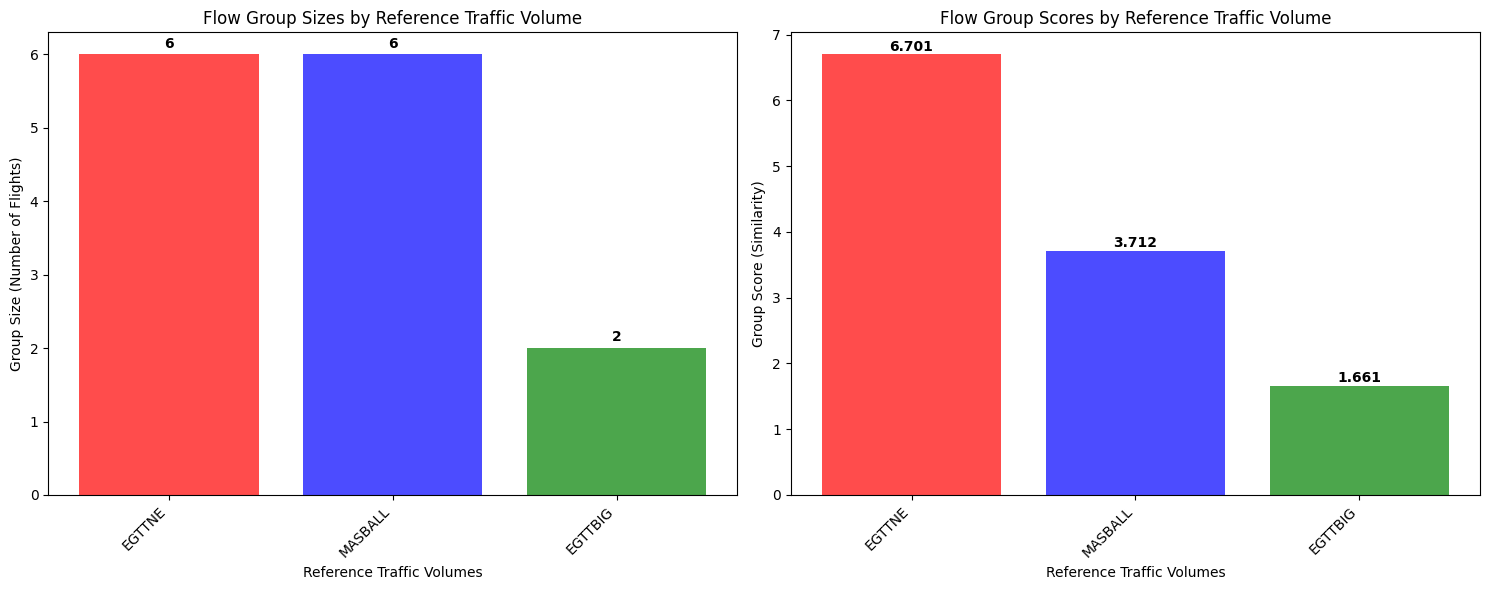


📊 Traffic Volume Statistics:
   Total Reference Sectors: 3
   Average Group Size: 4.7
   Average Group Score: 4.025
   Group 1: EGTTNE - 6 flights (score: 6.701)
   Group 2: MASBALL - 6 flights (score: 3.712)
   Group 3: EGTTBIG - 2 flights (score: 1.661)


In [69]:
# Step 4: Plot traffic volume statistics from flow extraction
flow_results = load_flow_extraction_results('../output/flow_extraction_results.txt')
if flow_results:
    plot_traffic_volume_statistics(flow_results, traffic_volumes)
else:
    print("❌ No flow results available - skipping traffic volume statistics")

In [70]:
# Step 2: Get trajectories for all matching flights
if matching_flights:
    flight_ids = [f['flight_id'] for f in matching_flights]
    trajectories = get_flight_trajectories(flight_ids, trajectory_df)
    
    print(f"\n📍 Successfully retrieved {len(trajectories)} out of {len(flight_ids)} flight trajectories")
    
    if len(trajectories) < len(flight_ids):
        missing_count = len(flight_ids) - len(trajectories)
        print(f"⚠️  {missing_count} flight trajectories not found in CSV data")
else:
    trajectories = {}

📍 Retrieved 20 flight trajectories

📍 Successfully retrieved 20 out of 20 flight trajectories



🗺️  Creating hotspot visualization for TVTW: MASB5KL at 06:00-06:15
   🛫 Number of flights: 20
   📍 Trajectories available: 20
   🔀 Flow-based coloring enabled: 14 flights in 3 groups
   🎯 Reference sectors: ['EGTTNE', 'MASBALL', 'EGTTBIG']
   ⏱️  Total occupancy time: 99:31
   ⏱️  Average occupancy per flight: 04:58
   🗺️  Map bounds focused on traffic volumes:
      Longitude: -6.81 to 13.33
      Latitude: 45.92 to 55.34


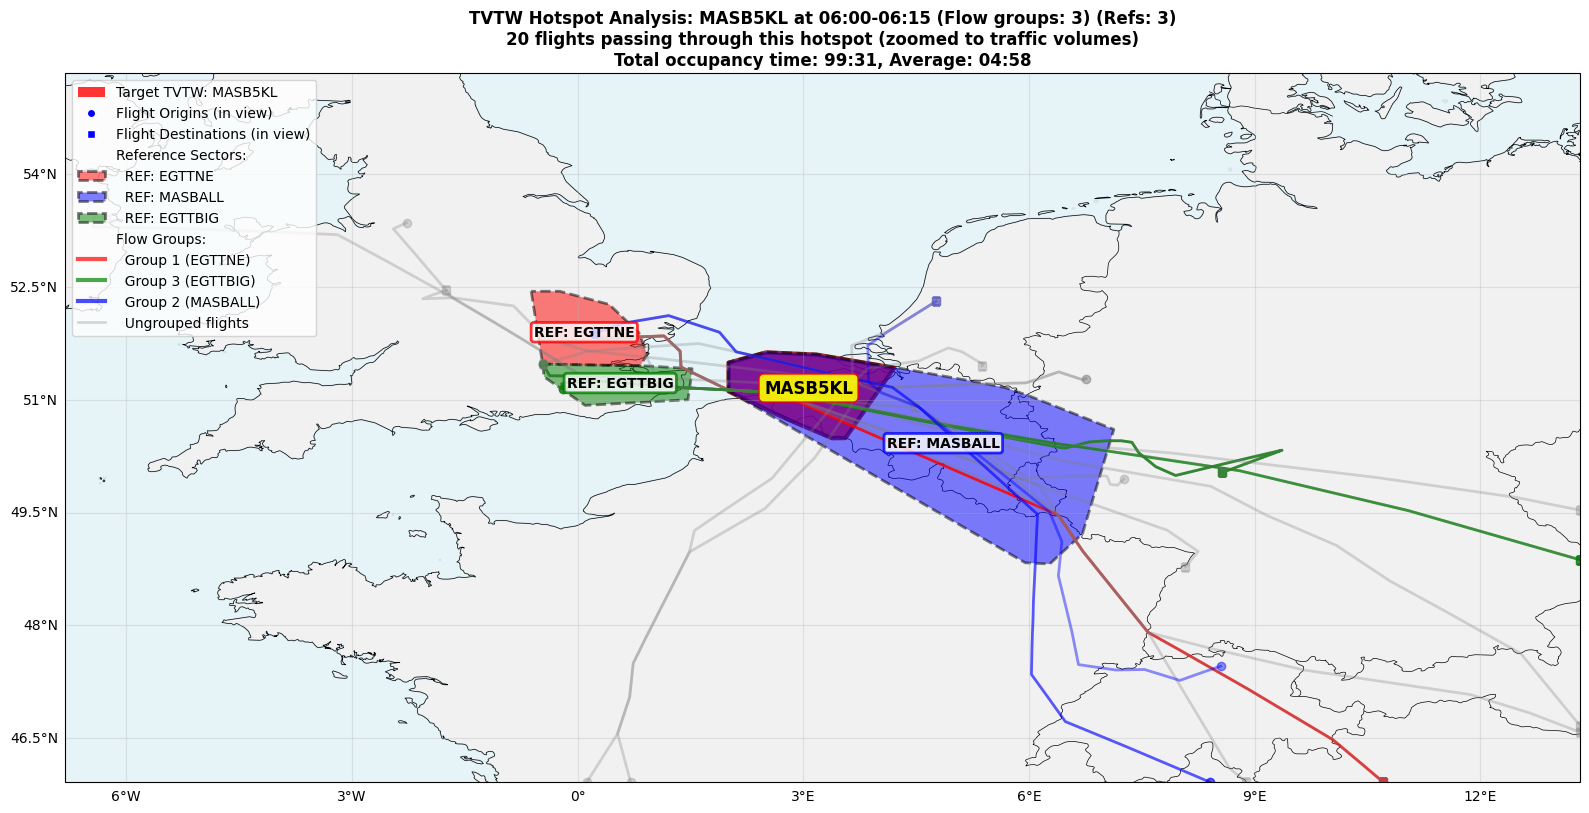


📊 TVTW Hotspot Summary:
   Traffic Volume: MASB5KL
   Time Window: 06:00-06:15
   Total Flights: 20
   Trajectories Plotted: 20 (clipped to traffic volume area)

🎯 Reference Traffic Volumes:
   - EGTTNE
   - MASBALL
   - EGTTBIG

🔀 Flow Group Summary:
   Group 1: 6 flights from reference EGTTNE
   Group 2: 6 flights from reference MASBALL
   Group 3: 2 flights from reference EGTTBIG

✈️  Flight Details:
    1.    30587 (EGKK → LDRI) - 04:18
    2.     9680 (EGSS → LIPE) - 06:59 [Group 1]
    3.    43625 (EGSS → LIBR) - 09:22
    4.     7758 (EGSS → EDSB) - 09:24
    5.    11579 (EGSS → LROP) - 04:32
    6.    15984 (EGLL → EDDF) - 08:06 [Group 3]
    7.    18431 (EGLL → LTFM) - 05:30
    8.    10275 (EGSS → LIRN) - 07:20
    9.    12922 (EDDL → EGBB) - 04:37
   10.    14324 (EGKK → LTAI) - 06:50
   ... and 10 more flights


In [71]:
# Step 3: Create TVTW hotspot visualization
if matching_flights and trajectories:
    plot_tvtw_hotspot_analysis(target_traffic_volume_id, target_time_bin, 
                              matching_flights, trajectories, traffic_volumes,
                              flow_results=flow_results, disable_label=True)
else:
    print("❌ Cannot create visualization - insufficient data")
    if not matching_flights:
        print("   No flights found for the specified TVTW")
    if not trajectories:
        print("   No trajectory data available for the flights")

## Debug: Traffic Volume Footprint Analysis

For debugging purposes, let's analyze the complete traffic volume footprint for the first 20 trajectories.

In [72]:
# Debug: Print complete traffic volume footprint for first 20 trajectories
if matching_flights:
    print(f"🔍 DEBUGGING: Traffic Volume Footprint for first 20 trajectories")
    print(f"=" * 80)
    
    for i, flight in enumerate(matching_flights[:20]):
        flight_id = flight['flight_id']
        flight_info = flight['flight_info']
        
        # Get call sign if available in trajectories
        call_sign = "N/A"
        if flight_id in trajectories:
            call_sign = trajectories[flight_id]['call_sign']
        
        print(f"\n📍 Flight {i+1}: {call_sign} (ID: {flight_id})")
        print(f"   Complete Traffic Volume Footprint:")
        
        # Get all occupancy intervals for this flight
        occupancy_intervals = flight_info.get('occupancy_intervals', [])
        
        if not occupancy_intervals:
            print(f"   ❌ No traffic volume footprint found")
            continue
            
        # Sort intervals by entry time for chronological order
        sorted_intervals = sorted(occupancy_intervals, key=lambda x: x['entry_time_s'])
        
        footprint_entries = []
        for interval in sorted_intervals:
            tvtw_index = interval['tvtw_index']
            
            # Get human readable TVTW info
            tvtw_data = tvtw_indexer.get_human_readable_tvtw(tvtw_index)
            if tvtw_data:
                tv_id, time_bin = tvtw_data
                footprint_entries.append(f"{tv_id} ({time_bin})")
            else:
                footprint_entries.append(f"UNKNOWN_TVTW_{tvtw_index}")
        
        # Print the complete footprint
        if footprint_entries:
            print(f"   📊 Total TVTWs: {len(footprint_entries)}")
            for j, entry in enumerate(footprint_entries):
                marker = "🎯" if entry.startswith(target_traffic_volume_id) else "  "
                print(f"   {marker} {j+1:2d}. {entry}")
        else:
            print(f"   ❌ No valid TVTW data found")
    
    if len(matching_flights) > 20:
        print(f"\n... (showing first 20 out of {len(matching_flights)} total flights)")
    
    print(f"\n" + "=" * 80)
    print(f"🎯 Target TVTW: {target_traffic_volume_id} ({target_time_bin})")
else:
    print("❌ No flights available for footprint analysis")

🔍 DEBUGGING: Traffic Volume Footprint for first 20 trajectories

📍 Flight 1: 30587 (ID: 263861449)
   Complete Traffic Volume Footprint:
   📊 Total TVTWs: 108
       1. EGTTBIG (05:45-05:60)
       2. EGTTBIG (06:00-06:15)
       3. EGCHAN (06:00-06:15)
       4. EGDLD (06:00-06:15)
       5. EG15GDVR (06:00-06:15)
       6. EGDVR (06:00-06:15)
       7. EGTTTIGD (06:00-06:15)
       8. EGLMU (06:00-06:15)
       9. MASB5WL (06:00-06:15)
      10. MASBWST (06:00-06:15)
      11. MASBALL (06:00-06:15)
   🎯 12. MASB5KL (06:00-06:15)
      13. MASB5WL (06:15-06:30)
   🎯 14. MASB5KL (06:15-06:30)
      15. MASBWST (06:15-06:30)
      16. MASBALL (06:15-06:30)
      17. MASB5WH (06:15-06:30)
      18. MASB5EH (06:15-06:30)
      19. MASBEST (06:15-06:30)
      20. MASBOLNU (06:15-06:30)
      21. MASBOLNW (06:15-06:30)
      22. MASBOLNI (06:15-06:30)
      23. MASBOLN (06:15-06:30)
      24. MASB5OH (06:15-06:30)
      25. MASBOLN (06:30-06:45)
      26. MASBOLNW (06:30-06:45)
      27. MA